In [1]:
import numpy as np
import CHONK_XL as chxl
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import xsimlab as xs
import CHONK_cpp as ch
import zarr
import helplotlib as hpl
import xarray as xr
from scipy.ndimage import gaussian_filter

# import helper as H
%matplotlib widget
%load_ext xsimlab.ipython
@xs.process
class CustomParameters:
	label_array = xs.variable(intent = 'in', dims = ('y','x'))
	label_list = xs.any_object()
	CHONK = xs.foreign(chxl.ChonkBase, "CHONK")
	nx = xs.foreign(chxl.ChonkBase, "nx")
	ny = xs.foreign(chxl.ChonkBase, "ny")
	dx = xs.foreign(chxl.ChonkBase, "dx")
	dy = xs.foreign(chxl.ChonkBase, "dy")
	
	active_nodes = xs.foreign(chxl.ChonkBase, "active_nodes")

	def initialize(self):

#		 self.landscape.add_pluton( dimless_X = 0.6, dimless_Y = 0.3, half_width = 5000,  half_heigth = 3000)
		self.label_list = []
	
		# self.label_array = self.landscape.indices

		self.label_list.append(ch.label(0))
		self.label_list[-1].m = 0.45;
		self.label_list[-1].n = 1;
		self.label_list[-1].base_K = 1e-5;
		self.label_list[-1].Ks_modifyer = 1.2;
		self.label_list[-1].Kr_modifyer = 0.8;
		self.label_list[-1].dimless_roughness = 0.5;
		self.label_list[-1].V = 0.5;
		self.label_list[-1].dstar = 1;
		self.label_list[-1].threshold_incision = 0;
		self.label_list[-1].threshold_entrainment = 0;
		self.label_list[-1].kappa_base = 1e-4;
		self.label_list[-1].kappa_r_mod = 0.8;
		self.label_list[-1].kappa_s_mod = 1.2;
		self.label_list[-1].critical_slope = 0.57835;
		self.label_list[-1].sensitivity_tool_effect = 1;

		self.label_list.append(ch.label(1))
		self.label_list[-1].m = 0.45;
		self.label_list[-1].n = 1;
		self.label_list[-1].base_K = 1e-5;
		self.label_list[-1].Ks_modifyer = 1;
		self.label_list[-1].Kr_modifyer = 0.3;
		self.label_list[-1].dimless_roughness = 0.5;
		self.label_list[-1].V = 0.1;
		self.label_list[-1].dstar = 1;
		self.label_list[-1].threshold_incision = 0;
		self.label_list[-1].threshold_entrainment = 0;
		self.label_list[-1].kappa_base = 1e-4;
		self.label_list[-1].kappa_r_mod = 0.8;
		self.label_list[-1].kappa_s_mod = 1.2;
		self.label_list[-1].critical_slope = 0.57835;
		self.label_list[-1].sensitivity_tool_effect = 1;

		self.CHONK.initialise_label_list(self.label_list)
		self.CHONK.update_label_array(self.label_array.ravel())

@xs.process
class UpliftRangeOld(chxl.Uplift):
    timing = xs.variable()
    intensity = xs.variable()
    smoothing_iterations = xs.variable()
    span = xs.variable(dims = 'minmax')
    
    uplift = xs.variable(dims=('y','x'), intent = 'inout')
    
    CHONK = xs.foreign(chxl.ChonkBase, "CHONK")
    
    
    def initialize(self):
        self.mod_done = False
                                    
    @xs.runtime(args=['step_delta','step_start'])
    def run_step(self, dt, this_time):
        # print (this_time)
        if(self.mod_done == False and this_time >= self.timing):
            toadd = np.zeros_like(self.uplift)
            toadd[self.span[0]:self.span[1]] = self.intensity
            toadd = gaussian_filter(toadd, self.smoothing_iterations)
            self.uplift = self.uplift + toadd
            self.mod_done = True
        
        self.CHONK.add_external_to_surface_elevation_tp1(self.uplift.ravel() * dt)
        self.uplift_done = True
        
@xs.process
class UpliftRange(chxl.Uplift): 
    pattern = xs.variable(dims=('y','x'), intent = 'inout')
    uplift = xs.variable(dims=('y','x'), intent = 'out')
    intensity = xs.variable()
    
    CHONK = xs.foreign(chxl.ChonkBase, "CHONK")
    
    
    def initialize(self):
        self.mod_done = False
        self.uplift = self.pattern * self.intensity
                                    
    @xs.runtime(args=['step_delta','step_start'])
    def run_step(self, dt, this_time):
        
        self.CHONK.add_external_to_surface_elevation_tp1(self.uplift.ravel() * dt)
        self.uplift_done = True
 


model = xs.Model({"ChonkBase": chxl.ChonkBase,
                "Runner": chxl.Runner,
                "Topography": chxl.Topography,
#                 "Uplift": UpliftLandscapeStSt,
#                 "Uplift": UpliftLandscape,
                # "Uplift": UpliftLandscapeNF1,
                "Uplift": UpliftRange,
                "Lake": chxl.Lake,
                "Precipitation": chxl.Precipitation,
#                 "DefaultParameters": chxl.DefaultParameters,
                "Params": CustomParameters,
                "Flow": chxl.Flow,
                "Fluvial": chxl.Fluvial,
                "Hillslope": chxl.Hillslope
            })

ny,nx = 200,200
dy,dx = 200,200
time = np.arange(0,1e7,1000)
otime = time[::20]

init_z = np.load("SS_topolake.npy")
init_z[0,:] = 600
# init_z = np.random.rand(ny,nx)


label_array = np.zeros((ny,nx), dtype = np.int32)
# label_array[40:80,40:80] = 1



label_array.shape

(200, 200)

(200, 200)

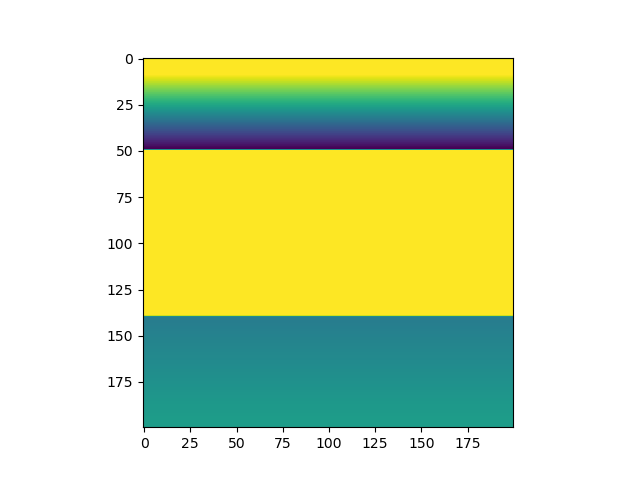

In [2]:
# Uplift shape
lU = np.zeros(ny)
lU[1:140] = 1
lU[10:50] = ( (1-0.33)/40 * np.arange(40) + 0.33 ) [::-1]
lU[140:] = ( (1-0.90)/60 * np.arange(60) + 0.91 ) - 1
lU[140:][lU[140:] >= 0] = 0
lU[1:140] -= 0.7
# lU[1:140]

U = np.zeros((ny,nx))
# U[:] = lU * 1
for i in range(nx):
    U[:,i] = lU
# U = np.rot90(U)[::-1]

U[[0,-1],:] = 0
fig, ax = plt.subplots()
ax.imshow(U)
U.shape

In [3]:
# %create_setup model
# import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={
        "time":time,
        "otime":otime
    },
    master_clock="time",
    input_vars={
        'ChonkBase__dx': dx,
        'ChonkBase__dy': dy,
        'ChonkBase__nx': nx,
        'ChonkBase__ny': ny,
        'ChonkBase__boundary_conditions': "periodic_EW",
        'ChonkBase__depths_res_sed_proportions': 1,
        'ChonkBase__n_depth_sed_tracking': 50,
        'ChonkBase__strati_recorder': True,
        'ChonkBase__path_strati': "strati_lake",
        'ChonkBase__pref_strati': "test1",
        'ChonkBase__create_folder_strati': False,
        'Topography__initial_elevation': init_z,
        'Topography__initial_carving': True,
        'Uplift__pattern': U,
        # run for the sensitivity on uplift intensity
        # 'Uplift__intensity':  xr.DataArray([1e-3,1.5e-3,2e-3], dims="batch"),
        # 'Uplift__intensity': xr.DataArray(np.arange(1e-4,5e-3,1e-4),dims='batch'),
        # 'Uplift__intensity': 1.2e-3,# USED FOR ALL BUT HACKY
        'Uplift__intensity': 0.5e-3,
        # 'Lake__method': "implicit",
        'Lake__method': "explicit",
        'Lake__Aincision_threshold': True,
        'Lake__evaporation': False,
        # 'Lake__evaporation_rate': xr.DataArray(np.arange(0.4,1.6,0.1),dims='batch'),
        'Lake__evaporation_rate': 1.5,
        'Precipitation__precipitation_rate': 0.7,
        # 'Precipitation__precipitation_rate': xr.DataArray(np.arange(0.4,0.8,0.05),dims='batch'),
        'Flow__threshold_single_flow': 1e12,
        'Params__label_array': label_array
    },
    output_vars=
    {
        'Topography__topography': 'otime',
        'Topography__sed_height': 'otime',
        'Flow__Qw': 'otime',
        'Flow__water_balance_checker': 'time',
        'Lake__lake_depth': 'otime',
        'Fluvial__Qs': 'otime',
        'Hillslope__Qs': 'otime',
        'ChonkBase__strati': 'otime',
        
        'ChonkBase__D_s':'otime',
        'ChonkBase__E_r':'otime',
        'ChonkBase__E_s':'otime',
        'ChonkBase__Q_sout_lab_N':'otime',
        'ChonkBase__Q_sout_lab_S':'otime',
    }
)

In [4]:
zg = zarr.group("section_lake_explicit_HACK.zarr", overwrite=True)
from dask.distributed import Client
if('client' in locals()):
    if(isinstance(client,Client)):
        client.close()
client = Client(n_workers=3, threads_per_worker=1)  

with model,xs.monitoring.ProgressBar():
    # out_ds = ds_in.xsimlab.run(store = zg, parallel = True, batch_dim = 'batch', scheduler=client)
    out_ds = ds_in.xsimlab.run(store = zg)#, parallel = True, batch_dim = 'batch', scheduler=client)
#     out_ds = mod1.xsimlab.run()  
out_ds.x.values[0] = 0
out_ds.y.values[0] = 0

             0% | initialize 

In [7]:
from ipyfastscape import TopoViz3d


app = TopoViz3d(out_ds, canvas_height=600, time_dim="otime", elevation_var = "Topography__topography" )

app.show()

Output(layout=Layout(height='640px'))

In [6]:
# out_ds = xr.open_zarr("section_lake_explicit_full_lake_find_ev.zarr")
# out_ds.x.values[0] = 0
# out_ds.y.values[0] = 0